# Łączenie metod detekcji

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
print("OK!")

OK!


In [2]:
def find_coin(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 100)
    kernel = np.ones((5,5), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=2)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    best = None
    best_area = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 5000:
            continue
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter ** 2)
        if circularity > 0.4 and area > best_area:
            best_area = area
            best = cnt
    if best is None:
        best = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(best)
    return (int(x), int(y), int(radius))

def extract_features(image):
    h, w = image.shape[:2]
    coin = find_coin(image)
    if coin is None:
        x, y = w // 2, h // 2
        radius = min(h, w) // 4
    else:
        x, y, radius = coin
    diameter = (radius * 2) / max(h, w)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (x, y), int(radius * 0.7), 255, -1)
    pixels = image[mask > 0]
    if len(pixels) < 100:
        cy, cx = h // 2, w // 2
        r = min(h, w) // 4
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (cx, cy), r, 255, -1)
        pixels = image[mask > 0]
    mean_r = np.mean(pixels[:, 0]) / 255
    mean_g = np.mean(pixels[:, 1]) / 255
    mean_b = np.mean(pixels[:, 2]) / 255
    std_r = np.std(pixels[:, 0]) / 255
    std_g = np.std(pixels[:, 1]) / 255
    std_b = np.std(pixels[:, 2]) / 255
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_pixels = hsv[mask > 0]
    mean_h = np.mean(hsv_pixels[:, 0]) / 180
    mean_s = np.mean(hsv_pixels[:, 1]) / 255
    mean_v = np.mean(hsv_pixels[:, 2]) / 255
    gold_ratio = mean_r / (mean_b + 0.001)
    brightness = (mean_r + mean_g + mean_b) / 3
    return np.array([diameter, mean_r, mean_g, mean_b, std_r, std_g, std_b,
                     mean_h, mean_s, mean_v, gold_ratio, brightness])

def load_dataset(data_dir):
    X, y = [], []
    for class_name in sorted(os.listdir(data_dir)):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        count = 0
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    X.append(extract_features(img))
                    y.append(class_name)
                    count += 1
        print(f"  {class_name}: {count}")
    return np.array(X), y

In [3]:
DATASET_PATH = "dataset"

print("=== TRAIN ===")
X_train, y_train = load_dataset(os.path.join(DATASET_PATH, "train"))
print(f"Razem: {len(X_train)}")

print("\n=== TEST ===")
X_test, y_test = load_dataset(os.path.join(DATASET_PATH, "test"))
print(f"Razem: {len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== TRAIN ===
  10gr: 20
  1gr: 20
  1zl: 20
  20gr: 20
  2gr: 20
  2zl: 20
  50gr: 20
  5gr: 20
  5zl: 20
Razem: 180

=== TEST ===
  10gr: 20
  1gr: 20
  1zl: 20
  20gr: 20
  2gr: 20
  2zl: 20
  50gr: 20
  5gr: 20
  5zl: 20
  wrong: 8
Razem: 188


---
## Kombinacja 1: Próg pewności + Isolation Forest (AND)
Wrong jeśli **OBA** mówią że anomalia

In [4]:
def combo1_and(X_train, y_train, X_test, prob_thresh=0.6, iso_contam=0.05):
    # SVM z prawdopodobieństwem
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    # Isolation Forest
    iso = IsolationForest(contamination=iso_contam, random_state=42)
    iso.fit(X_train)
    iso_pred = iso.predict(X_test)  # 1=normal, -1=anomaly
    
    # Kombinacja AND: wrong tylko jeśli OBA mówią anomalia
    predictions = []
    for i in range(len(X_test)):
        svm_says_wrong = max_proba[i] < prob_thresh
        iso_says_wrong = iso_pred[i] == -1
        
        if svm_says_wrong and iso_says_wrong:
            predictions.append('wrong')
        else:
            predictions.append(svm_pred[i])
    
    return predictions

print("=== Kombinacja 1: Próg + IsoForest (AND) ===")
for pt in [0.5, 0.6, 0.7]:
    for ic in [0.03, 0.05, 0.08]:
        pred = combo1_and(X_train_scaled, y_train, X_test_scaled, pt, ic)
        acc = accuracy_score(y_test, pred)
        print(f"  prob={pt}, iso={ic}: {acc*100:.2f}%")

=== Kombinacja 1: Próg + IsoForest (AND) ===
  prob=0.5, iso=0.03: 95.74%
  prob=0.5, iso=0.05: 95.74%
  prob=0.5, iso=0.08: 95.74%
  prob=0.6, iso=0.03: 97.87%
  prob=0.6, iso=0.05: 97.87%
  prob=0.6, iso=0.08: 97.87%
  prob=0.7, iso=0.03: 97.87%
  prob=0.7, iso=0.05: 97.34%
  prob=0.7, iso=0.08: 97.34%


---
## Kombinacja 2: Próg pewności + Isolation Forest (OR)
Wrong jeśli **KTÓRYKOLWIEK** mówi że anomalia

In [5]:
def combo2_or(X_train, y_train, X_test, prob_thresh=0.6, iso_contam=0.05):
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    iso = IsolationForest(contamination=iso_contam, random_state=42)
    iso.fit(X_train)
    iso_pred = iso.predict(X_test)
    
    # Kombinacja OR: wrong jeśli KTÓRYKOLWIEK mówi anomalia
    predictions = []
    for i in range(len(X_test)):
        svm_says_wrong = max_proba[i] < prob_thresh
        iso_says_wrong = iso_pred[i] == -1
        
        if svm_says_wrong or iso_says_wrong:
            predictions.append('wrong')
        else:
            predictions.append(svm_pred[i])
    
    return predictions

print("\n=== Kombinacja 2: Próg + IsoForest (OR) ===")
for pt in [0.5, 0.6, 0.7]:
    for ic in [0.01, 0.03, 0.05]:
        pred = combo2_or(X_train_scaled, y_train, X_test_scaled, pt, ic)
        acc = accuracy_score(y_test, pred)
        print(f"  prob={pt}, iso={ic}: {acc*100:.2f}%")


=== Kombinacja 2: Próg + IsoForest (OR) ===
  prob=0.5, iso=0.01: 92.02%
  prob=0.5, iso=0.03: 88.30%
  prob=0.5, iso=0.05: 84.57%
  prob=0.6, iso=0.01: 91.49%
  prob=0.6, iso=0.03: 87.23%
  prob=0.6, iso=0.05: 83.51%
  prob=0.7, iso=0.01: 84.57%
  prob=0.7, iso=0.03: 80.32%
  prob=0.7, iso=0.05: 77.13%


---
## Kombinacja 3: Próg pewności + KNN odległość (AND)

In [6]:
def combo3_prob_knn(X_train, y_train, X_test, prob_thresh=0.6, knn_thresh=2.5):
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    distances, _ = knn.kneighbors(X_test)
    mean_dist = np.mean(distances, axis=1)
    
    train_dist, _ = knn.kneighbors(X_train)
    threshold = np.mean(train_dist) + knn_thresh * np.std(np.mean(train_dist, axis=1))
    
    predictions = []
    for i in range(len(X_test)):
        svm_says_wrong = max_proba[i] < prob_thresh
        knn_says_wrong = mean_dist[i] > threshold
        
        if svm_says_wrong and knn_says_wrong:
            predictions.append('wrong')
        else:
            predictions.append(svm_pred[i])
    
    return predictions

print("\n=== Kombinacja 3: Próg + KNN odległość (AND) ===")
for pt in [0.5, 0.6, 0.7]:
    for kt in [2.0, 2.5, 3.0]:
        pred = combo3_prob_knn(X_train_scaled, y_train, X_test_scaled, pt, kt)
        acc = accuracy_score(y_test, pred)
        print(f"  prob={pt}, knn={kt}: {acc*100:.2f}%")


=== Kombinacja 3: Próg + KNN odległość (AND) ===
  prob=0.5, knn=2.0: 95.74%
  prob=0.5, knn=2.5: 95.74%
  prob=0.5, knn=3.0: 95.74%
  prob=0.6, knn=2.0: 97.34%
  prob=0.6, knn=2.5: 97.34%
  prob=0.6, knn=3.0: 97.34%
  prob=0.7, knn=2.0: 96.28%
  prob=0.7, knn=2.5: 96.28%
  prob=0.7, knn=3.0: 96.28%


---
## Kombinacja 4: Głosowanie (voting) - 3 metody

In [7]:
def combo4_voting(X_train, y_train, X_test, prob_thresh=0.6, iso_contam=0.05, knn_thresh=2.5, min_votes=2):
    # SVM
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    # Isolation Forest
    iso = IsolationForest(contamination=iso_contam, random_state=42)
    iso.fit(X_train)
    iso_pred = iso.predict(X_test)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    distances, _ = knn.kneighbors(X_test)
    mean_dist = np.mean(distances, axis=1)
    train_dist, _ = knn.kneighbors(X_train)
    knn_threshold = np.mean(train_dist) + knn_thresh * np.std(np.mean(train_dist, axis=1))
    
    predictions = []
    for i in range(len(X_test)):
        votes_wrong = 0
        if max_proba[i] < prob_thresh:
            votes_wrong += 1
        if iso_pred[i] == -1:
            votes_wrong += 1
        if mean_dist[i] > knn_threshold:
            votes_wrong += 1
        
        if votes_wrong >= min_votes:
            predictions.append('wrong')
        else:
            predictions.append(svm_pred[i])
    
    return predictions

print("\n=== Kombinacja 4: Głosowanie (3 metody) ===")
for min_v in [1, 2, 3]:
    pred = combo4_voting(X_train_scaled, y_train, X_test_scaled, 0.6, 0.05, 2.5, min_v)
    acc = accuracy_score(y_test, pred)
    print(f"  min_votes={min_v}: {acc*100:.2f}%")


=== Kombinacja 4: Głosowanie (3 metody) ===
  min_votes=1: 75.00%
  min_votes=2: 88.83%
  min_votes=3: 97.87%


---
## Kombinacja 5: Ważone głosowanie

In [8]:
def combo5_weighted(X_train, y_train, X_test, prob_thresh=0.6, iso_contam=0.05, score_thresh=0.5):
    # SVM
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    # Isolation Forest
    iso = IsolationForest(contamination=iso_contam, random_state=42)
    iso.fit(X_train)
    iso_scores = iso.decision_function(X_test)  # im niższy, tym bardziej anomalia
    iso_scores_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min())
    
    # Ważony score: wysoki = normalna moneta, niski = anomalia
    # SVM prob ma wagę 0.7, Isolation ma wagę 0.3
    combined_score = 0.7 * max_proba + 0.3 * iso_scores_norm
    
    predictions = []
    for i in range(len(X_test)):
        if combined_score[i] < score_thresh:
            predictions.append('wrong')
        else:
            predictions.append(svm_pred[i])
    
    return predictions

print("\n=== Kombinacja 5: Ważone głosowanie ===")
for st in [0.4, 0.45, 0.5, 0.55, 0.6]:
    pred = combo5_weighted(X_train_scaled, y_train, X_test_scaled, 0.6, 0.05, st)
    acc = accuracy_score(y_test, pred)
    print(f"  score_thresh={st}: {acc*100:.2f}%")


=== Kombinacja 5: Ważone głosowanie ===
  score_thresh=0.4: 95.74%
  score_thresh=0.45: 96.81%
  score_thresh=0.5: 97.87%
  score_thresh=0.55: 97.34%
  score_thresh=0.6: 95.74%


---
## Kombinacja 6: Kaskada (hierarchia decyzji)

In [9]:
def combo6_cascade(X_train, y_train, X_test, prob_high=0.8, prob_low=0.5, iso_contam=0.05):
    """
    Kaskada decyzji:
    1. Jeśli SVM bardzo pewny (>80%) -> akceptuj klasę
    2. Jeśli SVM niepewny (<50%) -> wrong
    3. Między 50-80% -> sprawdź Isolation Forest
    """
    svm = SVC(kernel='linear', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba = svm.predict_proba(X_test)
    max_proba = np.max(proba, axis=1)
    svm_pred = svm.predict(X_test)
    
    iso = IsolationForest(contamination=iso_contam, random_state=42)
    iso.fit(X_train)
    iso_pred = iso.predict(X_test)
    
    predictions = []
    for i in range(len(X_test)):
        if max_proba[i] >= prob_high:
            # Bardzo pewny -> akceptuj
            predictions.append(svm_pred[i])
        elif max_proba[i] < prob_low:
            # Bardzo niepewny -> wrong
            predictions.append('wrong')
        else:
            # Niepewny -> sprawdź IsoForest
            if iso_pred[i] == -1:
                predictions.append('wrong')
            else:
                predictions.append(svm_pred[i])
    
    return predictions

print("\n=== Kombinacja 6: Kaskada ===")
for ph in [0.7, 0.8, 0.85]:
    for pl in [0.4, 0.5, 0.6]:
        pred = combo6_cascade(X_train_scaled, y_train, X_test_scaled, ph, pl, 0.05)
        acc = accuracy_score(y_test, pred)
        print(f"  high={ph}, low={pl}: {acc*100:.2f}%")


=== Kombinacja 6: Kaskada ===
  high=0.7, low=0.4: 97.34%
  high=0.7, low=0.5: 96.81%
  high=0.7, low=0.6: 95.74%
  high=0.8, low=0.4: 92.55%
  high=0.8, low=0.5: 92.02%
  high=0.8, low=0.6: 90.96%
  high=0.85, low=0.4: 89.89%
  high=0.85, low=0.5: 89.36%
  high=0.85, low=0.6: 88.30%


---
## PODSUMOWANIE

In [10]:
print("\n" + "="*60)
print("PODSUMOWANIE - NAJLEPSZE WYNIKI")
print("="*60)

results = {}

# Bazowa metoda (sam próg)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
proba = svm.predict_proba(X_test_scaled)
max_proba = np.max(proba, axis=1)
svm_pred = svm.predict(X_test_scaled)
base_pred = ['wrong' if p < 0.6 else c for p, c in zip(max_proba, svm_pred)]
results['Bazowa (próg 0.6)'] = accuracy_score(y_test, base_pred)

# Najlepsze z każdej kombinacji
best_c1 = max([accuracy_score(y_test, combo1_and(X_train_scaled, y_train, X_test_scaled, pt, ic))
               for pt in [0.5, 0.6, 0.7] for ic in [0.03, 0.05, 0.08]])
results['Combo1 (AND)'] = best_c1

best_c2 = max([accuracy_score(y_test, combo2_or(X_train_scaled, y_train, X_test_scaled, pt, ic))
               for pt in [0.5, 0.6, 0.7] for ic in [0.01, 0.03, 0.05]])
results['Combo2 (OR)'] = best_c2

best_c3 = max([accuracy_score(y_test, combo3_prob_knn(X_train_scaled, y_train, X_test_scaled, pt, kt))
               for pt in [0.5, 0.6, 0.7] for kt in [2.0, 2.5, 3.0]])
results['Combo3 (Prob+KNN)'] = best_c3

best_c4 = max([accuracy_score(y_test, combo4_voting(X_train_scaled, y_train, X_test_scaled, 0.6, 0.05, 2.5, mv))
               for mv in [1, 2, 3]])
results['Combo4 (Voting)'] = best_c4

best_c5 = max([accuracy_score(y_test, combo5_weighted(X_train_scaled, y_train, X_test_scaled, 0.6, 0.05, st))
               for st in [0.4, 0.45, 0.5, 0.55, 0.6]])
results['Combo5 (Weighted)'] = best_c5

best_c6 = max([accuracy_score(y_test, combo6_cascade(X_train_scaled, y_train, X_test_scaled, ph, pl, 0.05))
               for ph in [0.7, 0.8, 0.85] for pl in [0.4, 0.5, 0.6]])
results['Combo6 (Cascade)'] = best_c6

for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {acc*100:.2f}%")

best_name = max(results, key=results.get)
print(f"\n>>> NAJLEPSZA: {best_name} ({results[best_name]*100:.2f}%) <<<")


PODSUMOWANIE - NAJLEPSZE WYNIKI
  Combo1 (AND): 97.87%
  Combo4 (Voting): 97.87%
  Combo5 (Weighted): 97.87%
  Combo3 (Prob+KNN): 97.34%
  Combo6 (Cascade): 97.34%
  Bazowa (próg 0.6): 96.28%
  Combo2 (OR): 92.02%

>>> NAJLEPSZA: Combo1 (AND) (97.87%) <<<


## Macierz pomyłek najlepszej metody

Najlepsza: Combo1 AND (prob=0.6, iso=0.03) - 97.87%


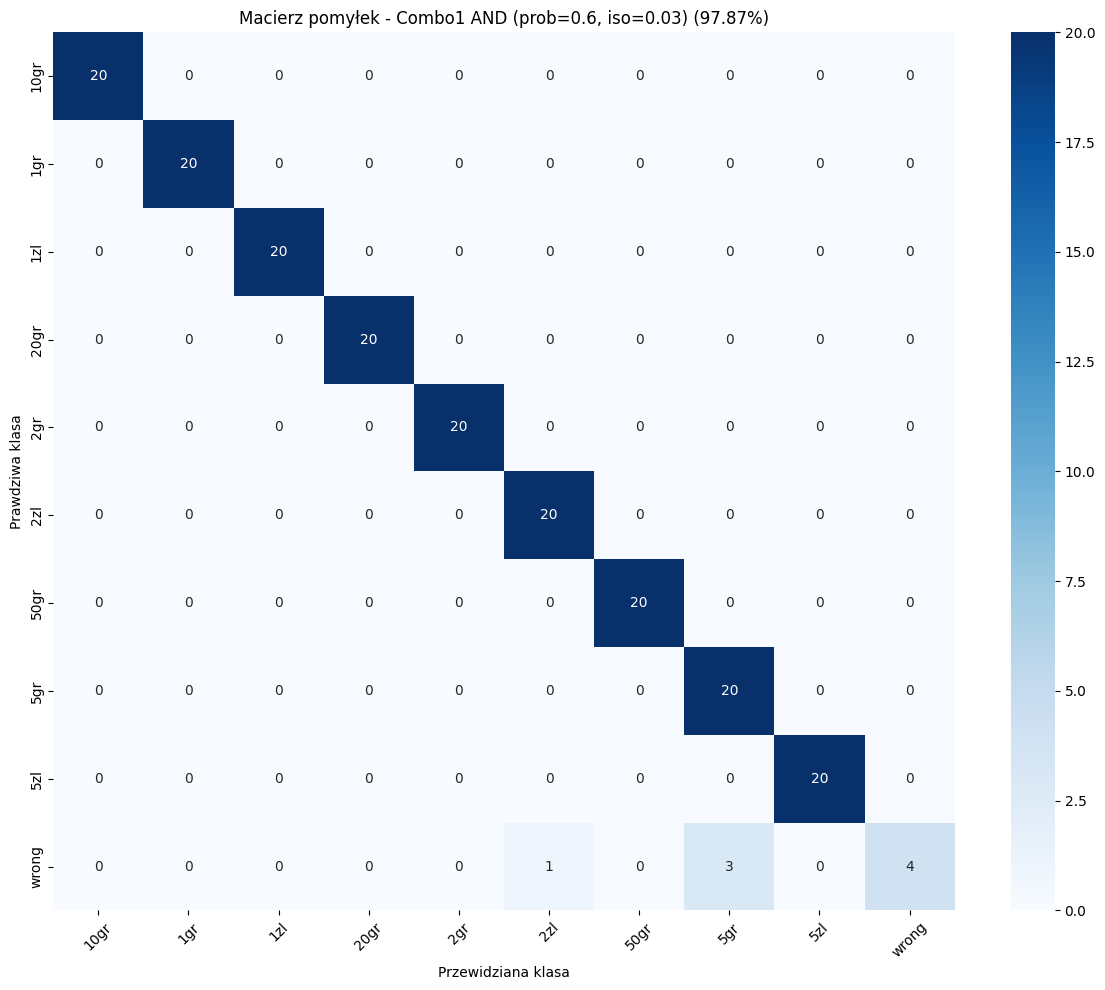


Raport klasyfikacji:
              precision    recall  f1-score   support

        10gr       1.00      1.00      1.00        20
         1gr       1.00      1.00      1.00        20
         1zl       1.00      1.00      1.00        20
        20gr       1.00      1.00      1.00        20
         2gr       1.00      1.00      1.00        20
         2zl       0.95      1.00      0.98        20
        50gr       1.00      1.00      1.00        20
         5gr       0.87      1.00      0.93        20
         5zl       1.00      1.00      1.00        20
       wrong       1.00      0.50      0.67         8

    accuracy                           0.98       188
   macro avg       0.98      0.95      0.96       188
weighted avg       0.98      0.98      0.98       188



In [11]:
# Znajdź najlepszą kombinację i jej parametry
best_acc = 0
best_pred = None
best_info = ""

# Sprawdź wszystkie kombinacje
for pt in [0.5, 0.6, 0.7]:
    for ic in [0.03, 0.05, 0.08]:
        pred = combo1_and(X_train_scaled, y_train, X_test_scaled, pt, ic)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc, best_pred, best_info = acc, pred, f"Combo1 AND (prob={pt}, iso={ic})"

for pt in [0.5, 0.6, 0.7]:
    for ic in [0.01, 0.03, 0.05]:
        pred = combo2_or(X_train_scaled, y_train, X_test_scaled, pt, ic)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc, best_pred, best_info = acc, pred, f"Combo2 OR (prob={pt}, iso={ic})"

for pt in [0.5, 0.6, 0.7]:
    for kt in [2.0, 2.5, 3.0]:
        pred = combo3_prob_knn(X_train_scaled, y_train, X_test_scaled, pt, kt)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc, best_pred, best_info = acc, pred, f"Combo3 Prob+KNN (prob={pt}, knn={kt})"

for mv in [1, 2, 3]:
    pred = combo4_voting(X_train_scaled, y_train, X_test_scaled, 0.6, 0.05, 2.5, mv)
    acc = accuracy_score(y_test, pred)
    if acc > best_acc:
        best_acc, best_pred, best_info = acc, pred, f"Combo4 Voting (min_votes={mv})"

for st in [0.4, 0.45, 0.5, 0.55, 0.6]:
    pred = combo5_weighted(X_train_scaled, y_train, X_test_scaled, 0.6, 0.05, st)
    acc = accuracy_score(y_test, pred)
    if acc > best_acc:
        best_acc, best_pred, best_info = acc, pred, f"Combo5 Weighted (thresh={st})"

for ph in [0.7, 0.8, 0.85]:
    for pl in [0.4, 0.5, 0.6]:
        pred = combo6_cascade(X_train_scaled, y_train, X_test_scaled, ph, pl, 0.05)
        acc = accuracy_score(y_test, pred)
        if acc > best_acc:
            best_acc, best_pred, best_info = acc, pred, f"Combo6 Cascade (high={ph}, low={pl})"

# Porównaj z bazową
if results['Bazowa (próg 0.6)'] >= best_acc:
    best_pred = base_pred
    best_info = "Bazowa (próg 0.6)"
    best_acc = results['Bazowa (próg 0.6)']

print(f"Najlepsza: {best_info} - {best_acc*100:.2f}%")

# Macierz
labels = sorted(list(set(y_test) | set(best_pred)))
cm = confusion_matrix(y_test, best_pred, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title(f'Macierz pomyłek - {best_info} ({best_acc*100:.2f}%)')
plt.ylabel('Prawdziwa klasa')
plt.xlabel('Przewidziana klasa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nRaport klasyfikacji:")
print(classification_report(y_test, best_pred))